<a href="https://colab.research.google.com/github/walid-ame/FaceMaskDetection/blob/main/face_mask_resnet9_new__dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset_url = 'https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset'

In [4]:
od.download(dataset_url)

100%|██████████| 207M/207M [00:05<00:00, 39.2MB/s]


In [5]:
data_dir = '/content/covid-face-mask-detection-dataset/New Masks Dataset/Train'

In [6]:
os.listdir(data_dir)

['Non Mask', 'Mask']

In [7]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Non Mask : 300
Mask : 300


In [8]:
from torchvision.datasets import ImageFolder

In [9]:
dataset = ImageFolder(data_dir)

dataset.classes

['Mask', 'Non Mask']

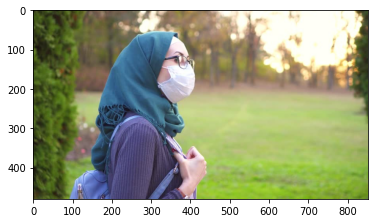

In [10]:

img, label = dataset[20]
plt.imshow(img)


In [17]:
train_dir = '/content/covid-face-mask-detection-dataset/New Masks Dataset/Train'
valid_dir = '/content/covid-face-mask-detection-dataset/New Masks Dataset/Validation'
test_dir = '/content/covid-face-mask-detection-dataset/New Masks Dataset/Test'

train_ds = ImageFolder(train_dir)
valid_ds = ImageFolder(valid_dir)
test_ds = ImageFolder(test_dir)

os.listdir(train_dir)

['Non Mask', 'Mask']

In [12]:
len(train_ds) , len(valid_ds), len(test_ds)

(600, 306, 100)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


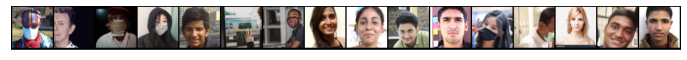

In [18]:
import torchvision.transforms as tt
train_ds = ImageFolder(train_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64 ),
                                             tt.ToTensor()]))

valid_ds = ImageFolder(valid_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64),
                                             tt.ToTensor()]))

test_ds = ImageFolder(test_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64 ),
                                             tt.ToTensor()]))

from torch.utils.data import DataLoader

batch_size = 16

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

test_dl = DataLoader(test_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

GPU Utilities

In [19]:


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

torch.cuda.is_available()

True

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
img, label = train_ds[0]
img.device

device(type='cpu')

In [22]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Training Utilties


In [24]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Evaluates the model's performance on the validation set

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model resnet9 with more than 6 million parameters

In [26]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 this adaptive make it always 00*00*1*1 force the dimition to be 1*1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [27]:
model = to_device(ResNet9(3, len(train_ds.classes)), device)
model
summary(model, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
         MaxPool2d-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 256,

In [28]:
model.conv1[0].weight.device

device(type='cuda', index=0)

test the model by passng one patch

In [29]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([16, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([16, 2])


the initial evaluation of the model before training 

In [30]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.4781250059604645, 'val_loss': 0.6979641318321228}]

train the model five by five 20 epoch 

In [31]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.6816, val_loss: 0.8954, val_acc: 0.7125
Epoch [1], train_loss: 0.4035, val_loss: 0.3996, val_acc: 0.8375
Epoch [2], train_loss: 0.3830, val_loss: 0.5653, val_acc: 0.8313
Epoch [3], train_loss: 0.2818, val_loss: 0.4711, val_acc: 0.8344
Epoch [4], train_loss: 0.2632, val_loss: 0.5192, val_acc: 0.7906


In [32]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.5399, val_loss: 0.4638, val_acc: 0.8062
Epoch [1], train_loss: 0.3072, val_loss: 0.2478, val_acc: 0.8969
Epoch [2], train_loss: 0.2337, val_loss: 0.2051, val_acc: 0.9219
Epoch [3], train_loss: 0.1918, val_loss: 0.4325, val_acc: 0.8313
Epoch [4], train_loss: 0.2027, val_loss: 0.3402, val_acc: 0.8469


In [33]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2737, val_loss: 0.2023, val_acc: 0.9125
Epoch [1], train_loss: 0.1432, val_loss: 0.1973, val_acc: 0.9281
Epoch [2], train_loss: 0.2424, val_loss: 0.4855, val_acc: 0.8687
Epoch [3], train_loss: 0.3426, val_loss: 0.4715, val_acc: 0.8406
Epoch [4], train_loss: 0.1659, val_loss: 0.2068, val_acc: 0.9406


In [34]:
history += fit(5, 0.001, model, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0905, val_loss: 0.1471, val_acc: 0.9344
Epoch [1], train_loss: 0.0732, val_loss: 0.1546, val_acc: 0.9250
Epoch [2], train_loss: 0.0688, val_loss: 0.1970, val_acc: 0.9344
Epoch [3], train_loss: 0.0821, val_loss: 0.1609, val_acc: 0.9312
Epoch [4], train_loss: 0.0837, val_loss: 0.1980, val_acc: 0.9219


In [35]:
history += fit(5, 0.001, model, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0829, val_loss: 0.1611, val_acc: 0.9281
Epoch [1], train_loss: 0.0627, val_loss: 0.1419, val_acc: 0.9406
Epoch [2], train_loss: 0.0601, val_loss: 0.1842, val_acc: 0.9250
Epoch [3], train_loss: 0.0969, val_loss: 0.1577, val_acc: 0.9375
Epoch [4], train_loss: 0.0742, val_loss: 0.1555, val_acc: 0.9438


In [36]:
history += fit(5, 0.001, model, train_dl, valid_dl)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0805, val_loss: 0.1877, val_acc: 0.9187
Epoch [1], train_loss: 0.0709, val_loss: 0.1603, val_acc: 0.9375
Epoch [2], train_loss: 0.1030, val_loss: 0.1449, val_acc: 0.9344
Epoch [3], train_loss: 0.0591, val_loss: 0.1540, val_acc: 0.9375
Epoch [4], train_loss: 0.0672, val_loss: 0.1697, val_acc: 0.9281


In [37]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2223, val_loss: 0.2125, val_acc: 0.9125
Epoch [1], train_loss: 0.0912, val_loss: 0.2031, val_acc: 0.9250
Epoch [2], train_loss: 0.1996, val_loss: 0.2511, val_acc: 0.9156
Epoch [3], train_loss: 0.0862, val_loss: 0.3126, val_acc: 0.9125
Epoch [4], train_loss: 0.0951, val_loss: 0.1821, val_acc: 0.9344


Results : plotting accuracy through Epochs 

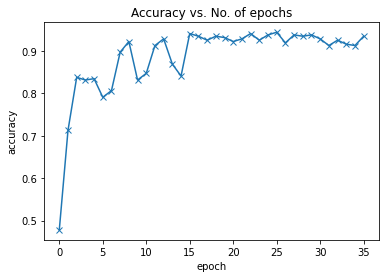

In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

Results : plotting losses 

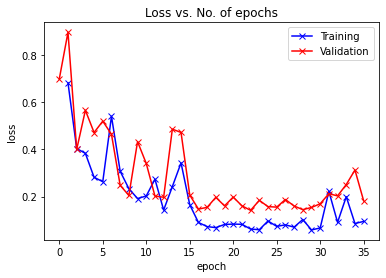

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

save the results

In [40]:
history[-1]

{'train_loss': 0.09512518346309662,
 'val_acc': 0.934374988079071,
 'val_loss': 0.18205313384532928}

In [41]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [43]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: Non Mask
Prediction: Non Mask


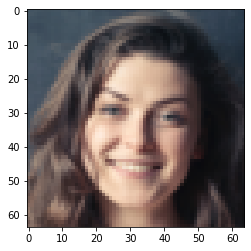

In [44]:
show_image_prediction(*valid_ds[200])

Target: Mask
Prediction: Mask


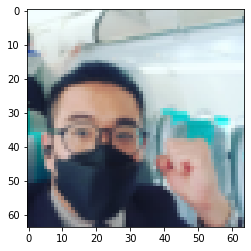

In [45]:
show_image_prediction(*valid_ds[100])

In [46]:
torch.save(model.state_dict(), 'facemask-resnet9-2.pth')